# Objective
### The aim of this notebook is to design the forward problem for the model of the sequence

In [1]:
import os
import sys
from bart import bart#required for importing bart
import cfl#for reading and writing data in bart compatible format

import numpy as np
from matplotlib import pyplot as plt
#%matplotlib inline

In [2]:
# loading the T1,T2 values, that have been previously estimated and will be treated as ground truth for right now. 
T2_values = np.load('subject2/Subject2_T2_vals_experimental.npy')
T1_values = np.load('subject2/Subject2_T1_vals_experimental.npy')
image_mask = np.load('subject2/Subject2_mask_experimental.npy')
subject2_PD = np.load('subject2/Subject2_PD.npy')
T1T2_vals = np.zeros((2,len(T1_values)))

T1T2_vals[0,:] = T1_values 
T1T2_vals[1,:] = T2_values
print(T1T2_vals.shape)

(2, 35818)


In [3]:
import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg
from tqdm import tqdm

#the function right now uses a certain format of sequences to simulated using the epg algorithm
def myfun(t1t2):
    sig_dict = {
        'T1': t1t2[0],
        'T2': t1t2[1],
    }
    TR_vals = np.array([860, 1830, 2800])
    TRs = TR_vals
    N_TRs = 3#number of reptitions to get the T1 weighting
    TE = 9.1*2
    ETL = 16
    angles_rad = np.ones((ETL))*180*np.pi/180
    signal = t2sh.t1t2shuffle2(angles_rad, TE, TRs, 1, T1= sig_dict['T1'], T2 = sig_dict['T2'], driven_equil = False, fr_sign = False)
    return signal/np.linalg.norm(signal)

In [4]:
par_jobs = 32
from multiprocessing import Pool
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, T1T2_vals.T), total=len(T1T2_vals.T), leave=True)))

100%|██████████| 35818/35818 [00:05<00:00, 6681.57it/s]


In [5]:
X_sim3 = np.array(result_dict).T#simulated signal evolutions
print(X_sim3.shape)

(48, 35818)


In [6]:
brain_phantom = np.zeros([288,288,48])#trying to generate the brain phantom for the 3*16 TE values
for index in range(48):
    Im_synthetic = np.zeros([288,288])
    Im_synthetic[np.nonzero(image_mask)] = X_sim3.T[:,index]
    brain_phantom[:,:,index] = Im_synthetic*subject2_PD
    
brain_phantom = brain_phantom[:,:,None,None,None,:]
print(brain_phantom.shape)

brain_phantom_fft = bart(1,'fft -u -i 3',brain_phantom)#going to the k-space for all the coil images

(288, 288, 1, 1, 1, 48)


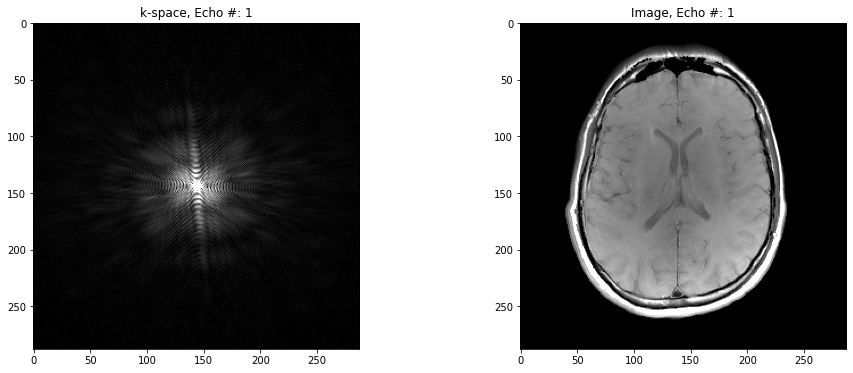

In [7]:
echo_index = 1
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(np.abs(brain_phantom_fft[:,:,0,0,0,echo_index]), cmap='gray',vmin=0,vmax = .0005)
plt.title('k-space, Echo #: ' + str(echo_index))
plt.subplot(1,2,2)
plt.imshow(np.abs(brain_phantom[:,:,0,0,0,echo_index]), cmap='gray',vmax = .00025,vmin=0)
plt.title('Image, Echo #: ' + str(echo_index))
plt.show()

coil_sens shape:  (288, 288, 1, 8)


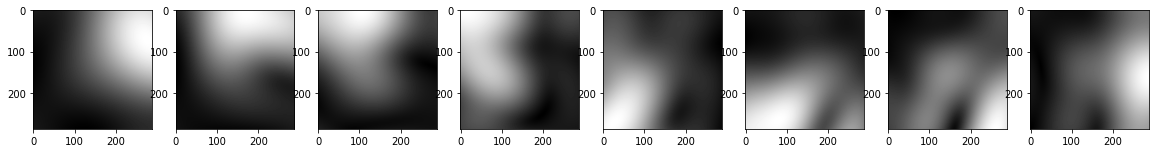

Coil Sensitivity images


In [8]:
#coil sensitivities in the image domain, because they are applied in image domain in the forward model

coil_sens = bart(1,'phantom -x 288 -S 8')#time domian sensitivities square right now
print('coil_sens shape: ',coil_sens.shape)

for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(coil_sens[:,:,0,index]),cmap=plt.get_cmap('gray'))
plt.show()
print('Coil Sensitivity images')

coil_sens = bart(1,'normalize 8',coil_sens)#need to normalize the sensitivity maps along each coil

In [9]:
print(coil_sens.shape,brain_phantom.shape)

(288, 288, 1, 8) (288, 288, 1, 1, 1, 48)


In [10]:
#only multiply the sensitivity map in image space because this is where we have the forward model says
image_with_coil_sens = bart(1,'fmac',coil_sens,brain_phantom) #in image-space generate the data for the different coils 
image_with_coil_sens_fft = bart(1,'fft -u 3',image_with_coil_sens)#going to the k-space for all the coil images
print(image_with_coil_sens_fft.shape)

(288, 288, 1, 8, 1, 48)


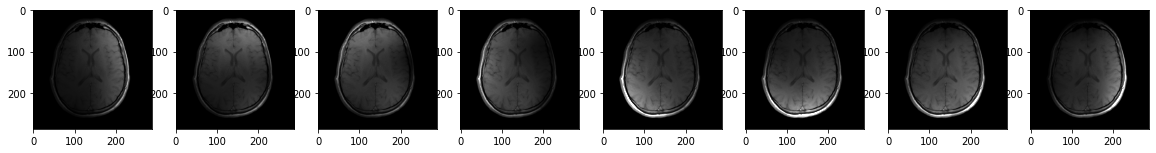

Brain images as acquired by different coils


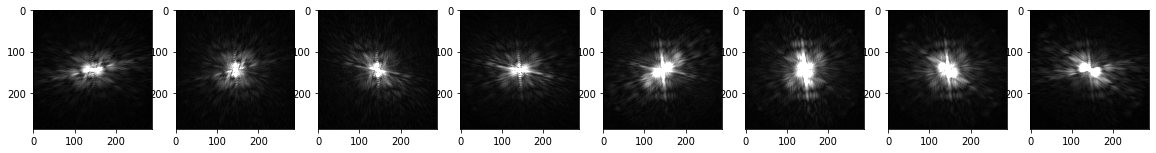

Brain images (in k-space) as acquired by different coils


In [11]:
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(image_with_coil_sens[:,:,0,index,0,0]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .00025)
plt.show()
print('Brain images as acquired by different coils')
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(image_with_coil_sens_fft[:,:,0,index,0,0]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .0001)
plt.show()
print('Brain images (in k-space) as acquired by different coils')

(288, 288)


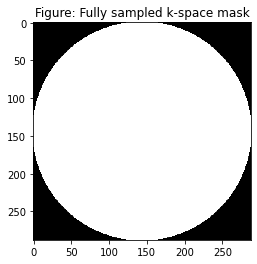

In [13]:
#generating masks for fully sampling the k-space domain
kspace_mask = bart(1,'t2sh_gen_mask -Y 288 -Z 288 -d 1 -C 3 -V 5 -r 1 -T 1 -E 1 -F')
kspace_mask = kspace_mask.squeeze()
print(kspace_mask.shape)
plt.imshow(np.abs(kspace_mask[:,:]).squeeze(), cmap='gray',vmax = 0.1,vmin=0)
plt.title('Figure: Fully sampled k-space mask')
plt.show()

In [14]:
#generating k-space data for the fully sampled case with 8 coils
fully_sampled_fft = bart(1,'fmac',image_with_coil_sens_fft,kspace_mask)
print(fully_sampled_fft.shape)

(288, 288, 1, 8, 1, 48)


## Upto this point the forward problem is done for the case of fully sampled case, from next cell we will start working on the inverse problem
### The idea would be to first evaluate the coil sensitivities and then applying the iterative algorithm to force the model and evaluate the (T1,T2) parameters from this data. 

In [15]:
#estimating the coil sensitivity of each coil
k_space_coils_data = fully_sampled_fft[:,:,0,:,0,0].squeeze()
print(k_space_coils_data.shape)
#ecalib accepts a particular shape of input data hence the last step needed
coil_sens_estimated = bart(1, 'ecalib -m 8 -a -d 0', k_space_coils_data[:,:,None,:]).squeeze()
print(coil_sens_estimated.shape)#The fourth dimension here is spurious

(288, 288, 8)
(288, 288, 8, 8)


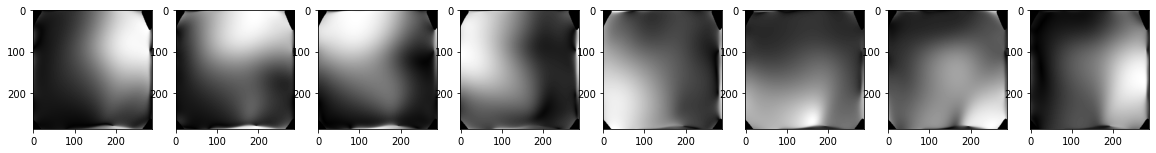

Estimated Coil Sensitivity images


In [16]:
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(coil_sens_estimated[:,:,index,0]),cmap=plt.get_cmap('gray'))
plt.show()
print('Estimated Coil Sensitivity images')